In [25]:
import pandas as pd
from tfidf import extract_column, tf_idf, load_table, create_wordcloud, max_row
from search_engine import keyword_search1
from scraper_guardian import create_relational_databases
import logging

# Suppress only urllib3 debug logs
logging.getLogger("urllib3").setLevel(logging.WARNING)

The purpose of this project is to identify 15 keywords of the top 100 novels, rated by the guardian.com. The following steps are necessary:

- Scraping book titles and authors from theguardian.com
- Scraping descriptions of books from goodreads.com
- Compute TF-IDF scores of each word in the corpus
- Choose 15 words with the highest TF-IDF for each book

First we execute a custom scraping function.

In [3]:
# Scrape data and enter into a relational database
create_relational_databases()

100%|██████████| 100/100 [00:00<00:00, 104.79it/s]


Then we check the database.

In [26]:
sql_books = load_table("books.db", "books")
corpus = extract_column(sql_books, "description")
for description in corpus:
    print(description)
print(f"Number of Books: {len(corpus)}")

This famous story of man's progress through life in search of salvation remains one of the most entertaining allegories of faith ever written. Set against realistic backdrops of town and country, the powerful drama of the pilgrim's trials and temptations follows him in his harrowing journey to the Celestial City. Along a road filled with monsters and spiritual terrors, Christian confronts such emblematic characters as Worldly Wiseman, Giant Despair, Talkative, Ignorance, and the demons of the Valley of the Shadow of Death. But he is also joined by Hopeful and Faithful. An enormously influential 17th-century classic, universally known for its simplicity, vigor, and beauty of language,  The Pilgrim's Progress  remains one of the most widely read books in the English language.
Daniel Defoe relates the tale of an English sailor marooned on a desert island for nearly three decades. An ordinary man struggling to survive in extraordinary circumstances, Robinson Crusoe wrestles with fate and t

Carefully examining the descriptions, we find one book description which is in greek, for "Sister Carrie" by "Theodore Dreiser". The goodreads description, for some reason is entirely in greek. We want to replace that description for an english one. Since this is a single case, we search an english description of the book, and insert it into our database. We take the one from pennpress.org:



In [21]:
description_sister_carrie = "Hidden under layers of error and corruption, the original version of Sister Carrie has finally emerged. The American classic that has been read in English courses for many decades is not the text as Dreiser wrote it. Even before it was submitted to Doubleday, Page and Company, the manuscript of Sister Carrie had been cut and censored. Dreiser's wife Sara-­-nicknamed Jug —and his friend Arthur Henry persuaded the author to make many changes. Both Jug and Henry felt that the novel was too bleak, the sexuality too explicit, the philosophy too intense. In a description of Carrie, for instance, Dreiser had written, Her dresses draped her becomingly, for she wore excellent corsets and laced herself with care. . . . She had always been of cleanly instincts and now that opportunity afforded, she kept her body sweet. Apparently this passage was too intimate for Jug, for she revised it to: Her dresses draped her becomingly. . . . She had always been of cleanly instincts. Her teeth were white, her nails rosy. Jug and Henry urged Dreiser to make his bleak ending more equivocal. He changed it, but Jug, still dissatisfied, rewrote his second ending. Her version was published with the first edition and has appeared with every edition since printed. Doubleday, Page and Company further insisted that all real names—of theaters, bars, streets, actors, etc.—be changed to fictitious ones. The editors of this new edition have gone back to the original handwritten manuscript as well as to the typescript that went to the publisher and have restored the text of Sister Carrie to its original purity. Errors of typists and printers have been corrected; cut and censored passages have been reinstated. Not only have original names been restored, but the Pennsylvania edition includes maps, illustrations, and historical notes that further identify these people and places. The edition also includes a selected textual apparatus for the scholar. The characters are significantly altered in this new text: Carrie has more emotional depth, conscience, and sexuality; Hurstwood shows more passion; Drouet is a bit less likable; Ames is a bit more vulnerable. With the inclusion of the original ending, Dreiser's vision becomes- more bleak and deterministic: In its expanded and purified form, Sister Carrie is more tragic and infinitely richer; in effect it is a new work of art by one of the major American novelists of this century."

In [22]:
from cs50 import SQL
db = SQL("sqlite:///books.db")
db.execute("UPDATE books SET description = ? WHERE title = ?;", description_sister_carrie, "SISTER CARRIE")

1

In [23]:
# Check if successful
db.execute("SELECT * FROM books WHERE title = 'SISTER CARRIE'")

[{'book_id': 33,
  'title': 'SISTER CARRIE',
  'description': "Hidden under layers of error and corruption, the original version of Sister Carrie has finally emerged. The American classic that has been read in English courses for many decades is not the text as Dreiser wrote it. Even before it was submitted to Doubleday, Page and Company, the manuscript of Sister Carrie had been cut and censored. Dreiser's wife Sara-\xad-nicknamed Jug —and his friend Arthur Henry persuaded the author to make many changes. Both Jug and Henry felt that the novel was too bleak, the sexuality too explicit, the philosophy too intense. In a description of Carrie, for instance, Dreiser had written, Her dresses draped her becomingly, for she wore excellent corsets and laced herself with care. . . . She had always been of cleanly instincts and now that opportunity afforded, she kept her body sweet. Apparently this passage was too intimate for Jug, for she revised it to: Her dresses draped her becomingly. . . . 

Let's further see if there are any descriptions that are inadequate. For example, do the descriptions have enough words for us to extract 15 key words? We will not tokenize the data yet, but just split by whitespaces, assuming that there are no symbols that seperate words. Let's say we want to detect descriptions with less than 30 words:

In [30]:
insufficient_words = {}
for dict in sql_books:
    description = dict['description'].split(" ")
    title = dict['title']
    if len(description) <= 30:
        insufficient_words[title] = len(description)


In [31]:
print(insufficient_words)

{'THE PRIME OF MISS JEAN BRODIE': 23}


We see that the book 'The Prime of Miss Jean Brodie' has only 23 strings seperated by whitespaces. Let's take a look:

In [26]:
db.execute("SELECT * FROM books WHERE title = 'THE PRIME OF MISS JEAN BRODIE'")

[{'book_id': 79,
  'title': 'THE PRIME OF MISS JEAN BRODIE',
  'description': 'In her 1961 novel, The Prime of Miss Jean Brodie, Muriel Spark brings to life an eccentric, egocentric, and charming teacher in a private Edinburgh school during the 1930s. Miss Brodie’s six students, known collectively as “the Brodie set,” move through the grades. Miss Brodie sabotages school curriculum as she grandstands her own passions, both personal and academic. She colludes with her students regarding her status in the school and trouble she has with the headmistress. Miss Brodie is memorable for these students, recalled in their later lives, as repeated flash-forwards reveal. Indeed, it is in putting this 1930s story in personal and historical perspective that some of its darker meaning emerges. In the pre–World War II days, autocratic, orderly, and foolish Miss Brodie is infatuated with Mussolini and Hitler. Inclined to think of herself as European, Miss Brodie praises fascism, her very taste for it

We see that the number of words matches the number we got earlier. This might not be enough and will inflate our tf-idf scores. We therefore use an alternative description provided by encyclopedia.com:

In [27]:
description_jean_brodie = "In her 1961 novel, The Prime of Miss Jean Brodie, Muriel Spark brings to life an eccentric, egocentric, and charming teacher in a private Edinburgh school during the 1930s. Miss Brodie’s six students, known collectively as “the Brodie set,” move through the grades. Miss Brodie sabotages school curriculum as she grandstands her own passions, both personal and academic. She colludes with her students regarding her status in the school and trouble she has with the headmistress. Miss Brodie is memorable for these students, recalled in their later lives, as repeated flash-forwards reveal. Indeed, it is in putting this 1930s story in personal and historical perspective that some of its darker meaning emerges. In the pre–World War II days, autocratic, orderly, and foolish Miss Brodie is infatuated with Mussolini and Hitler. Inclined to think of herself as European, Miss Brodie praises fascism, her very taste for it a sign of her cultivation. Deluded by the appeal of absolute domination, with its apparent order and efficiency, Miss Brodie forgets that each person, however low and powerless, is a human being with rights. In her ridicule of Mary Macgregor, in her irresponsible direction to Joyce Emily Hammond to go off and fight for Franco, and in her attempt to sexually manipulate Rose Stanley, Miss Brodie sets morality aside and denies the humanity of her students. Mary’s death in a fire in 1943 connects this denial to the greater obscenity occurring at the same time on the Continent in the death camps. In sum, readers are at first charmed and amused, and then jolted into pondering the serious, indeed dangerous, side of this nostalgic portrait of the 1930s and pubescent childhood."

In [28]:
db = SQL("sqlite:///books.db")
db.execute("UPDATE books SET description = ? WHERE title = ?;", description_jean_brodie, "THE PRIME OF MISS JEAN BRODIE")

1

In [35]:
# Check if successful
display(db.execute("SELECT * FROM books WHERE title = 'THE PRIME OF MISS JEAN BRODIE'"))

sql_books = load_table("books.db", "books")
insufficient_words = {}
for dict in sql_books:
    description = dict['description'].split(" ")
    title = dict['title']
    if len(description) <= 30:
        insufficient_words[title] = len(description)

print(insufficient_words)

[{'book_id': 79,
  'title': 'THE PRIME OF MISS JEAN BRODIE',
  'description': 'In her 1961 novel, The Prime of Miss Jean Brodie, Muriel Spark brings to life an eccentric, egocentric, and charming teacher in a private Edinburgh school during the 1930s. Miss Brodie’s six students, known collectively as “the Brodie set,” move through the grades. Miss Brodie sabotages school curriculum as she grandstands her own passions, both personal and academic. She colludes with her students regarding her status in the school and trouble she has with the headmistress. Miss Brodie is memorable for these students, recalled in their later lives, as repeated flash-forwards reveal. Indeed, it is in putting this 1930s story in personal and historical perspective that some of its darker meaning emerges. In the pre–World War II days, autocratic, orderly, and foolish Miss Brodie is infatuated with Mussolini and Hitler. Inclined to think of herself as European, Miss Brodie praises fascism, her very taste for it

{}


Now we are ready to lemmatize the descriptions and calculate TF-IDF scores. I wrote a function that does lemmatization and stopwords/numerics/symbol/whitespace removal, and outputs a sparse matrix of the shape (documents, lemmas) of the TF-IDF scores, and a vector of all unique lemmas. 

It is important to note that the tf_idf() function includes an argument called max_df. Any lemmas that occur in more than max_df% of the books will be excluded. We do not want lemmas that occur to frequently, even if they are not in our list of stop words. I've set it to 50% here.

We also want to filter out any nonsense words (such as 'yr') so we remove any tokens that are less than 3 characters long.

In [27]:
X, feature_names = tf_idf(corpus, 0.5)

In [29]:
n_words = X.shape[1]
print(f"shape of matrix: {X.shape}")
print(f"Number of tokens: {n_words}")


shape of matrix: (100, 2953)
Number of tokens: 2953


As can be seen, we have a total of 2953 lemmas in our corpus, and 295300 total TF-IDF scores.

Now, we extract 15 lemmas with the highest TF-IDF scores for each book. In order to do so, we first transform the sparse matrix to a pandas dataframe:

In [30]:
df_tfidf = pd.DataFrame(X.toarray(), columns=feature_names)


In [31]:
display(df_tfidf.head())

,abandon,abbey,ability,able,abolitionist,abound,abrupt,abruptly,absolute,absolutely,...,yield,york,yorker,yorkshire,young,youth,yr,yule,yvonne,zuleika
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.101328,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now select, in descending order, 15 words of each book with the highest TF-IDF count. I again use custom functions: 

In [32]:
# Extract the top 15 words per document
top_15_words = max_row(df_tfidf, 15, index=True)

# Extract the top 15 tf-idf values per document
top_15_tfidf = max_row(df_tfidf, 15)

print(top_15_words.head())
print(len(top_15_words[0]))

0    [pilgrim, progress, language, remain, celestia...
1    [daniel, maroon, nearly, sailor, wrestle, deca...
2    [society, voyage, land, penguin, bear, travel,...
3    [woman, instinctual, nature, psyche, soul, wil...
4    [tom, sophia, jones, penguin, introduction, li...
dtype: object
15


We then plot some wordclouds to display the 15 words with the highest TF-IDF for each book. The books chosen here are not randomly chosen, I will clarify later on why these books were selected:

In [33]:
titles = extract_column(sql_books, 'title')
selected_titles = ["THE WIND IN THE WILLOWS", "WUTHERING HEIGHTS", "DRACULA", "THE NARRATIVE OF ARTHUR GORDON PYM OF NANTUCKET", "ULYSSES"]
t15_words_summaries = []
t15_tfidf_summaries = []
for title in selected_titles:
    idx = titles.index(title)
    t15_words_summaries.append(top_15_words.iloc[idx])
    t15_tfidf_summaries.append(top_15_tfidf.iloc[idx])

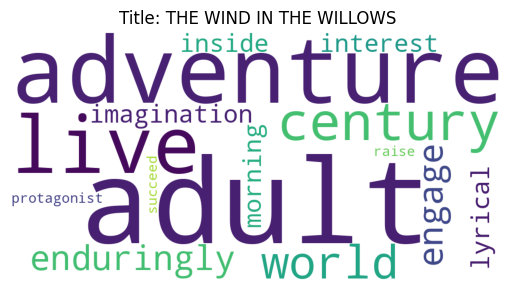

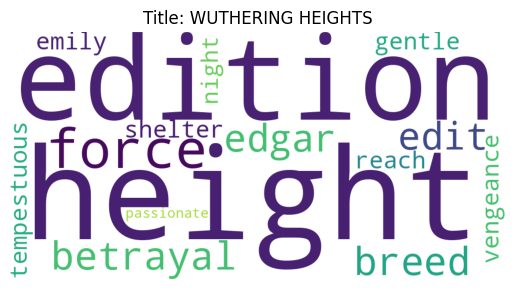

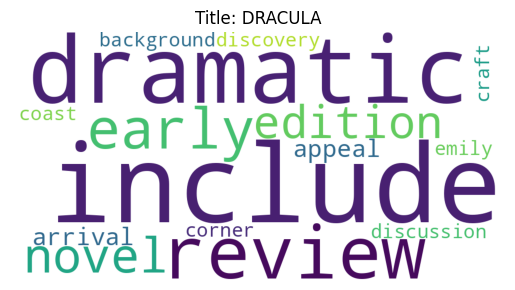

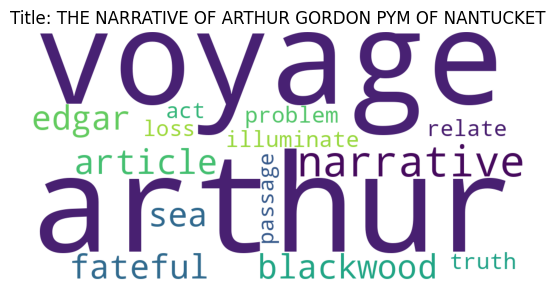

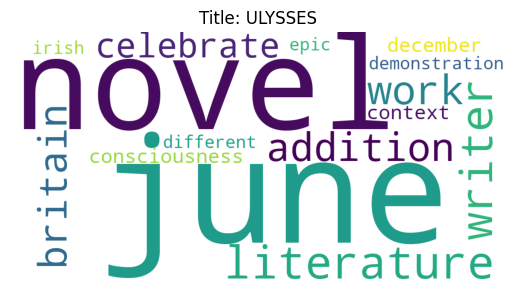

In [43]:
# Extract book titles
titles = extract_column(sql_books, 'title')

# Construct word clouds for the first 5 books
for title, words, values in zip(selected_titles, t15_words_summaries, t15_tfidf_summaries):
    create_wordcloud(words, values, title)

In [10]:
# Search function using keywords
keyword = "help"
print(keyword_search1(X, feature_names, keyword, titles, 5))

[('UNDERWORLD', 0.17225344577793664), ('THE SUN ALSO RISES', 0.10191492255246501), ('VOSS', 0.09329062081293142), ('CLARISSA', 0.07794085323434163), ('MURPHY', 0.07193550329326494)]


### Do keywords provide more information using full texts?

As can be seen, there are some words that are informative ("edgar" in Wuthering Heights) and some that don't seem so ('live' in The wind in the willows is a fairly standard word). Perhaps the keywords can be improved further?

We used summaries to calculate tfidf scores, and used those to determine characteristic words for each book. If we use the full text of the books instead, do we get more informative keywords? In order to determine this, we need to define what 'more informative' means. TF-IDF reflects the informativeness of a single token, so to compare the informativeness of the document, we can take the average TF-IDF across the document. This tells us, on average, how informative both documents are. The idea is that if full texts are more informative, they should generate consistently higher TF-IDF scores for the tokens within the corpus.

Unfortunately, free texts of books are not easy to come by, and Project Gutenberg (one of the few sites offering full texts) don't have every single book of our top 100. The books that we have selected before are definitely available as txt files on their website:


THE WIND IN THE WILLOWS

WUTHERING HEIGHTS

DRACULA

THE NARRATIVE OF ARTHUR GORDON PYM OF NANTUCKET

ULYSSES


We will first scrape these from Project Gutenberg. As these are only 5 titles, available as txt files on the website server, I simply identified the ID of each book and downloaded the respective txt files:

In [34]:
from scraper_guardian import get_full_text

In [35]:
# Gutenberg ID for the selected titles
ids = ["289", "768", "345", "51060", "4300"]
selected_titles = ["THE WIND IN THE WILLOWS", "WUTHERING HEIGHTS", "DRACULA", "THE NARRATIVE OF ARTHUR GORDON PYM OF NANTUCKET", "ULYSSES"]
full_text_dict = {}

for i in range(len(ids)):
    full_text = get_full_text(ids[i])
    full_text_dict[selected_titles[i]] = full_text

In [36]:
full_text_dict["ULYSSES"]

'ULYSSES ***\r\n\r\n[Illustration]\r\n\r\n\r\n\r\n\r\nUlysses\r\n\r\n\r\nby James Joyce\r\n\r\n\r\nContents\r\n\r\n — I —\r\n\r\n [  1 ]\r\n [  2 ]\r\n [  3 ]\r\n\r\n — II —\r\n\r\n [  4 ]\r\n [  5 ]\r\n [  6 ]\r\n [  7 ]\r\n [  8 ]\r\n [  9 ]\r\n [ 10 ]\r\n [ 11 ]\r\n [ 12 ]\r\n [ 13 ]\r\n [ 14 ]\r\n [ 15 ]\r\n\r\n — III —\r\n\r\n [ 16 ]\r\n [ 17 ]\r\n [ 18 ]\r\n\r\n\r\n\r\n\r\n— I —\r\n\r\n\r\n[ 1 ]\r\n\r\nStately, plump Buck Mulligan came from the stairhead, bearing a bowl of\r\nlather on which a mirror and a razor lay crossed. A yellow\r\ndressinggown, ungirdled, was sustained gently behind him on the mild\r\nmorning air. He held the bowl aloft and intoned:\r\n\r\n—_Introibo ad altare Dei_.\r\n\r\nHalted, he peered down the dark winding stairs and called out coarsely:\r\n\r\n—Come up, Kinch! Come up, you fearful jesuit!\r\n\r\nSolemnly he came forward and mounted the round gunrest. He faced about\r\nand blessed gravely thrice the tower, the surrounding land and the\r\nawaking mount

Now, lets calculate the tf-idf matrix. We extract the texts from the dictionary into a nested list:

In [37]:
full_text_list = []
for title in selected_titles:
    full_text_list.append(full_text_dict[title])

# Sanity Check    
print(full_text_list[0][:200])

THE WIND IN THE WILLOWS ***

[Illustration]




The Wind in the Willows

by Kenneth Grahame

Author Of “The Golden Age,” “Dream Days,” Etc.


Contents

 CHAPTER I. THE RIVER BANK
 CHA


Now we lemmatize the 5 books. Note that I've set the max_df argument to 0.8, which is higher than previously. The reason is that we only have 5 books here, so we basically say that if a word is contained in 4 out of 5 books, it will be excluded 

We compute the matrix (Some texts have over 1.5 million tokens, this will take around 2 minutes) **You can just load the variables using the loading cell below**:

In [38]:
# Takes long time, use the loading cell below!!!
full_X, full_feature_names = tf_idf(full_text_list, max_df=0.8)

We pickle the variables, so we don't have to compute them again:

In [39]:
import pickle

In [40]:
# Saves the variables
with open("full_text_results.pkl", "wb") as f:
    pickle.dump((full_X, full_feature_names), f)
    

In [41]:
# Loads the variables
with open("full_text_results.pkl", "rb") as f:
    full_X, full_feature_names = pickle.load(f)

We can now inspect the sparse matrix:

In [42]:
print(f"Matrix shape: {full_X.shape}")

Matrix shape: (5, 17752)


The lemmatization and filter seems to have reduced the tokens substantially, to around 17752 words. 

We now do the same as before, and check out the Top 15 words of the full texts:

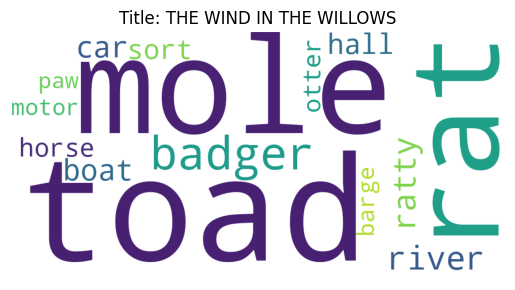

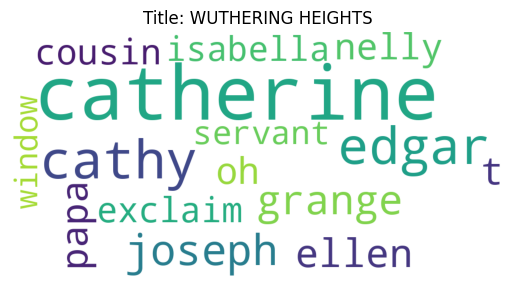

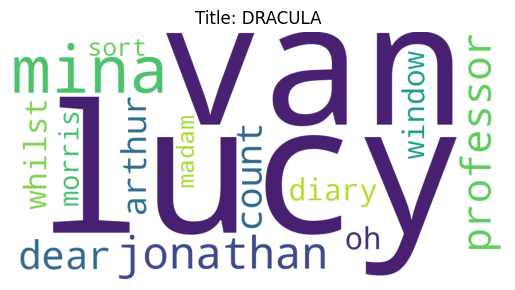

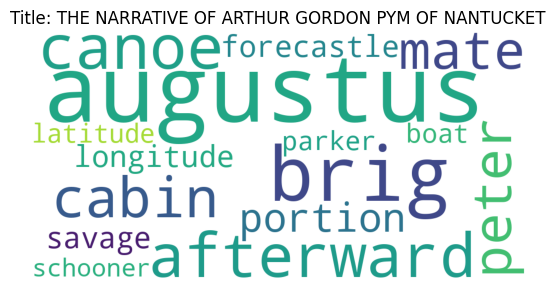

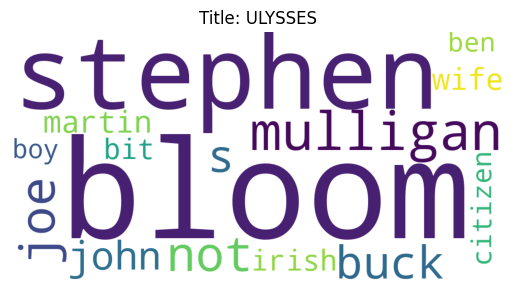

In [44]:
full_df_tfidf = pd.DataFrame(full_X.toarray(), columns=full_feature_names)
full_top_15_words = max_row(full_df_tfidf, 15, index = True)
full_top_15_tfidf = max_row(full_df_tfidf, 15)
for title, words, values in zip(selected_titles, full_top_15_words, full_top_15_tfidf):
    create_wordcloud(words, values, title)


In [59]:
print(full_top_15_words)
for l in range(len(full_top_15_words)):
    print(f"TITLE: {selected_titles[l]}")
    display(full_top_15_words[l])
    print(" ")

0    [mole, car, otter, barge, washerwoman, luncheo...
1    [catherine, grange, t, papa, cousin, isabella,...
2    [lucy, mina, jonathan, professor, whilst, morr...
3    [augustus, brig, longitude, guy, berth, vicini...
4    [s, irish, citizen, henry, professor, today, m...
dtype: object
TITLE: THE WIND IN THE WILLOWS


['mole',
 'car',
 'otter',
 'barge',
 'washerwoman',
 'luncheon',
 'poop',
 'canal',
 'contentment',
 'ditch',
 'portly',
 'toady',
 'gaoler',
 'pond',
 'sentry']

 
TITLE: WUTHERING HEIGHTS


['catherine',
 'grange',
 't',
 'papa',
 'cousin',
 'isabella',
 'dean',
 'uncle',
 'affirm',
 'kenneth',
 'lattice',
 'naughty',
 'aversion',
 'bonny',
 'behaviour']

 
TITLE: DRACULA


['lucy',
 'mina',
 'jonathan',
 'professor',
 'whilst',
 'morris',
 'telegram',
 'record',
 'clue',
 'pier',
 'crucifix',
 'bat',
 'catherine',
 'murray',
 'solicitor']

 
TITLE: THE NARRATIVE OF ARTHUR GORDON PYM OF NANTUCKET


['augustus',
 'brig',
 'longitude',
 'guy',
 'berth',
 'vicinity',
 'albatross',
 'jane',
 'antarctic',
 'excessively',
 'musket',
 'navigator',
 'reader',
 'allen',
 'grampus']

 
TITLE: ULYSSES


['s',
 'irish',
 'citizen',
 'henry',
 'professor',
 'today',
 'm',
 'thou',
 'lambert',
 'eh',
 'car',
 'hamlet',
 'ad',
 'jack',
 'william']

Interestingly, these words don't seem more informative, compared to the keywords extracted from the summaries...

We now look at the average TF-IDF per book for full-text vs summary:

In [60]:
full_averages = {}
for i, l in enumerate(full_top_15_tfidf):
    av_tfidf = sum(l) / len(l)
    full_averages[selected_titles[i]] = av_tfidf

summary_averages = {}
for i, l in enumerate(t15_tfidf_summaries):
    av_tfidf = sum(l) / len(l)
    summary_averages[selected_titles[i]] = av_tfidf

print(full_averages)
print(summary_averages)

{'THE WIND IN THE WILLOWS': 0.11333941226898173, 'WUTHERING HEIGHTS': 0.14693585882170632, 'DRACULA': 0.17231712808041463, 'THE NARRATIVE OF ARTHUR GORDON PYM OF NANTUCKET': 0.1576882616730527, 'ULYSSES': 0.17096872230431837}
{'THE WIND IN THE WILLOWS': 0.1592463904526276, 'WUTHERING HEIGHTS': 0.18674416936558275, 'DRACULA': 0.15674295349988043, 'THE NARRATIVE OF ARTHUR GORDON PYM OF NANTUCKET': 0.2006604020580727, 'ULYSSES': 0.15670641380213982}


We see that in fact 3 of the 5 titles we chose, the average tf-idf for the top 15 keywords is higher for the summaries than for the full text. It seems that using the full text for our 5 examples is not better than using the summaries. 